In [1]:
import pandas as pd
from spacy import displacy
import spacy
import dateparser
import ezodf
import textacy
from tqdm import tqdm_notebook as tqdm
from pymagnitude import *
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import string
import gensim
import seaborn as sns

# DS
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, recall_score, precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout

%matplotlib inline

Using TensorFlow backend.


In [2]:
nlp = spacy.load('fr_core_news_md')

In [3]:
def read_ods(filename, sheet_no=0, header=0):
    tab = ezodf.opendoc(filename=filename).sheets[sheet_no]
    return pd.DataFrame({col[header].value:[x.value for x in col[header+1:]]
                         for col in tab.columns()})

In [4]:
df = read_ods(filename='/home/aleksei/Documents/corefr/data/corefrus.ods', sheet_no=0).iloc[:, :4]
df = df.astype({"file": str, "doc_id": int, "event_id": int, "text" : str})

In [5]:
df.shape

(499, 4)

In [6]:
df.head(10)

file  doc_id  event_id  \
0  txts_1.tsv       3         1   
1  txts_1.tsv       3         1   
2  txts_1.tsv       3         1   
3  txts_1.tsv       3         1   
4  txts_1.tsv       3         1   
5  txts_1.tsv       3         2   
6  txts_1.tsv       3         1   
7  txts_1.tsv       4         2   
8  txts_1.tsv       4         1   
9  txts_1.tsv       5         1   

                                                text  
0  Invité dans le bureau Ovale, le rappeur s’est ...  
1  Le président américain entouré de sa jeune gar...  
2  Téléphone posé sur le Resolute Desk, qu’il a m...  
3  « Je vais vous dire quelque chose, c’était ass...  
4  Le matin, lors d’une interview sur Fox News, D...  
5  A rebours de la plupart des rappeurs, Kanye We...  
6  Sans surprise, l’apparition de Kanye West au c...  
7  Après l\'élection du candidat républicain, Kan...  
8  Coiffé d\'une casquette "Make America Great Ag...  
9  La scène est pour le moins singulière: un rapp...

In [7]:
data_corpus = {'file1':[], 'file2':[], 'doc_id1':[], 'doc_id2':[], 'event_id1':[], 'event_id2':[], 'text1':[], 'text2':[], 'areCoref':[]}

In [8]:
for i in range(df.shape[0]):
    coref_d1 = df.loc[i, :]
    coref_d2 = df.drop([df.index[i],]).reset_index(drop=True)
    for a in range(coref_d2.shape[0]):
        data_corpus["file1"].append(coref_d1.file)
        data_corpus["file2"].append(coref_d2.file[a])
        
        data_corpus["doc_id1"].append(coref_d1.doc_id)
        data_corpus["doc_id2"].append(coref_d2.doc_id[a])
        
        data_corpus["event_id1"].append(coref_d1.event_id)
        data_corpus["event_id2"].append(coref_d2.event_id[a])
        
        data_corpus["text1"].append(coref_d1.text)
        data_corpus["text2"].append(coref_d2.text[a])
        
        if coref_d1.event_id == coref_d2.event_id[a]:
            data_corpus["areCoref"].append(1)
        else:
            data_corpus["areCoref"].append(0)

In [9]:
df_c = pd.DataFrame(data=data_corpus)

In [12]:
df_c.areCoref.value_counts()

0    234128
1     14374
Name: areCoref, dtype: int64

In [14]:
df_c.head()

file1       file2  doc_id1  doc_id2  event_id1  event_id2  \
0  txts_1.tsv  txts_1.tsv        3        3          1          1   
1  txts_1.tsv  txts_1.tsv        3        3          1          1   
2  txts_1.tsv  txts_1.tsv        3        3          1          1   
3  txts_1.tsv  txts_1.tsv        3        3          1          1   
4  txts_1.tsv  txts_1.tsv        3        3          1          2   

                                               text1  \
0  Invité dans le bureau Ovale, le rappeur s’est ...   
1  Invité dans le bureau Ovale, le rappeur s’est ...   
2  Invité dans le bureau Ovale, le rappeur s’est ...   
3  Invité dans le bureau Ovale, le rappeur s’est ...   
4  Invité dans le bureau Ovale, le rappeur s’est ...   

                                               text2  areCoref  
0  Le président américain entouré de sa jeune gar...         1  
1  Téléphone posé sur le Resolute Desk, qu’il a m...         1  
2  « Je vais vous dire quelque chose, c’était ass...         1  
3  Le matin, lors d’une interview sur Fox News, D...         1  
4  A rebours de la plupart des rappeurs, Kanye We...         0

In [3]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  # deacc=True removes accents, do no use

In [4]:
stop_add = ['\n',' ', '\n\n', '...', '-PRON-', '1', '2', '3', '4', '5', '6']
non_stop = ['shall','could','should','must','may','can','have', 'has']
stoplist = set(list(stopwords.words('french')) + list(stopwords.words('french')) + list(string.punctuation) \
               + list(nlp.Defaults.stop_words) + stop_add)
stoplist = [i for i in stoplist if i not in non_stop]

--------------------

In [5]:
df_c = pd.read_pickle('df_c')

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  # deacc=True removes accents, do no use

In [6]:
vectors = Magnitude('/home/aleksei/Documents/corefr/data/cc-fr-300.magnitude')

In [8]:
vectors.dim

300

In [9]:
tokenized_train_1 = list(sent_to_words(df_c.text1))

In [10]:
tokenized_train_2 = list(sent_to_words(df_c.text2))

In [14]:
def get_sent_vector_fasttext(train):
    sent_vectors = list()
    for sent in tqdm(range(len(train))):
        print(sent)
        try:
            vect = vectors.query(train[sent])
            if vect.size == 0:
                m = np.mean(sent_vectors)
                sent_vectors.append(m)
            else:
                m = np.mean(vect)
                sent_vectors.append(m)
        except:
            sent_vectors.append(np.mean(sent_vectors))
        
    return sent_vectors

In [ ]:
sent_vectors_1 = pd.Series(get_sent_vector_fasttext(tokenized_train_1))
sent_vectors_1.rename('hasVector_1', inplace=True)

In [ ]:
sent_vectors_2 = pd.Series(get_sent_vector_fasttext(tokenized_train_2))
sent_vectors_2.rename('hasVector_2', inplace=True)

In [18]:
df_c = pd.concat([df_c.reset_index(drop=True),
                    sent_vectors_1.reset_index(drop=True),
                    sent_vectors_2.reset_index(drop=True)], 
                    axis=1)

In [20]:
df_c.to_pickle('df_c_featurized')

------------------

In [2]:
df_c = pd.read_pickle('df_c_featurized')

In [328]:
df_c = df_c.iloc[:100000, :]

In [3]:
df_c.shape

(248502, 11)

In [4]:
def cs(df):
    pippo = []
    for i in range(df.shape[0]):
        p = cosine_similarity(vectors.query(df.text1[i]).reshape(1,-1), vectors.query(df.text2[i]).reshape(1,-1))
        pippo.append(p[0][0])
        
    return pippo

In [7]:
df_c['cs'] = pd.Series(cs(df_c))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_c, df_c['areCoref'], test_size=0.20)

In [9]:
X_train.areCoref.value_counts()

0    187445
1     11356
Name: areCoref, dtype: int64

In [10]:
X_test_check = X_test.copy()

In [11]:
X_train = X_train.iloc[:, np.r_[9,10,11]]

In [12]:
X_test = X_test.iloc[:, np.r_[9,10,11]]

----------------

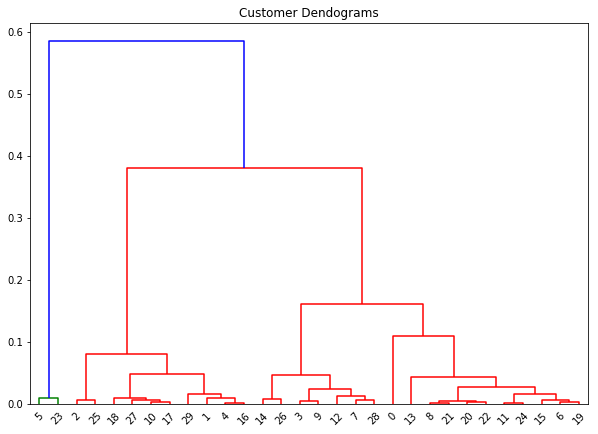

In [37]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(X_train.iloc[:30, :], method='ward'))  

In [420]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={1: 10})
X_cc, y_cc = cc.fit_sample(X_train, y_train)

In [356]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X_train, y_train)

print('Removed indexes:', id_rus)

Removed indexes: [ 76547 172515 111219 ... 198757 198764 198786]


In [316]:
dummy_classifier = DummyClassifier(random_state=17)
dummy_classifier.fit(X_rus,y_rus)

DummyClassifier(constant=None, random_state=17, strategy='stratified')

In [317]:
y_true, y_pred_dummy = y_test, dummy_classifier.predict(X_test)
print(classification_report(y_true, y_pred_dummy))
print()

              precision    recall  f1-score   support

           0       0.94      0.50      0.65     46795
           1       0.06      0.50      0.10      2906

   micro avg       0.50      0.50      0.50     49701
   macro avg       0.50      0.50      0.38     49701
weighted avg       0.89      0.50      0.62     49701




In [226]:
mlp = MLPClassifier()

In [233]:
param_grid_mlp_v3 = {
    'hidden_layer_sizes': [
             (1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,)
             ],
    'activation': ['identity', 'relu'],
    'solver': ['adam',],
    'alpha': [0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [235]:
scores = ['roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    mlp_CV = GridSearchCV(estimator=mlp,
                      param_grid=param_grid_mlp_v3,
                      cv = 5,
                      n_jobs =-1,
                      verbose = 4,
                      scoring='%s' % score)
    
    mlp_CV.fit(X_rus, y_rus)

    print("Best parameters set found on development set:")
    print()
    print(mlp_CV.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = mlp_CV.cv_results_['mean_test_score']
    stds = mlp_CV.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, mlp_CV.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, mlp_CV.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for roc_auc



TypeError: __init__() got an unexpected keyword argument 'class_weight'

----------------

In [421]:
model = Sequential()

batch_size = 32
epochs = 5

model.add(Dense(32, activation="relu", input_dim=3))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.10))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [ ]:
model.fit(X_cc, y_cc, epochs=epochs, batch_size=batch_size)

Epoch 1/5
187300/187300 [==============================] - 11s 58us/step - loss: 0.0080 - acc: 0.9999
Epoch 2/5
187300/187300 [==============================] - 9s 50us/step - loss: 7.4757e-04 - acc: 0.9999
Epoch 3/5
187300/187300 [==============================] - 9s 50us/step - loss: 6.8005e-04 - acc: 0.9999
Epoch 4/5
 15008/187300 [=>............................] - ETA: 8s - loss: 0.0018 - acc: 0.9999

In [417]:
predictions = model.predict(X_test, batch_size=32)

In [418]:
predictions = [0 if pred<0.5 else 1 for pred in predictions ]

In [419]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     46795
           1       0.06      1.00      0.11      2906

   micro avg       0.06      0.06      0.06     49701
   macro avg       0.03      0.50      0.06     49701
weighted avg       0.00      0.06      0.01     49701



/home/aleksei/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aleksei/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aleksei/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------

In [87]:
for chunk in doc.noun_chunks:
    print(chunk.text)

Téléphone posé sur le Resolute Desk, qu’il a martelé à de nombreuses reprises pour scander son propos, et coiffé de la célèbre casquette rouge barrée du slogan de campagne
Make America Great Again
le rappeur de Chicago
un feu d’artifice verbal
de son paysage mental chaotique


-----------------------